*First compiled: May 5, 2017.*

# Profiling Seurat's guided clustering tutorial for 3k PBMC cells

In [1]:
library(Seurat)
library(dplyr)
library(Matrix)

# Load the PBMC dataset
pbmc.data <- Read10X("data/pbmc3k_filtered_gene_bc_matrices/hg19")

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘dplyr’

The following object is masked from ‘package:Seurat’:

    arrange

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
previous_time <- proc.time()[3]
# Initialize the Seurat object with the raw (non-normalized data)
# Note that this is slightly different than the older Seurat workflow, where log-normalized values were passed in directly.
# You can continue to pass in log-normalized values, just set do.logNormalize=F in the next step.
pbmc <- new("seurat", raw.data = pbmc.data)

# Keep all genes expressed in >= 3 cells, keep all cells with >= 200 genes
# Perform log-normalization, first scaling each cell to a total of 1e4 molecules (as in Macosko et al. Cell 2015)
pbmc <- Setup(pbmc, min.cells = 3, min.genes = 200, do.logNormalize = T, total.expr = 1e4, project = "10X_PBMC")
proc.time()[3] - previous_time

elapsed 
  14.04

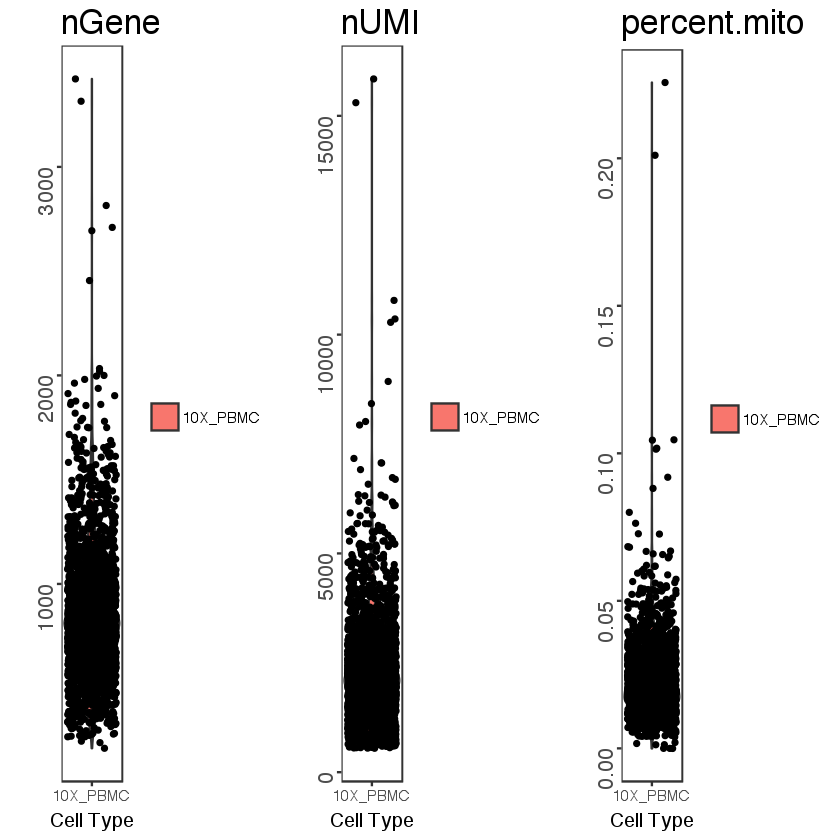

In [3]:
# The number of genes and UMIs (nGene and nUMI) are automatically calculated for every object by Seurat. 
# For non-UMI data, nUMI represents the sum of the non-normalized values within a cell
# We calculate the percentage of mitochondrial genes here and store it in percent.mito using the AddMetaData. 
# The % of UMI mapping to MT-genes is a common scRNA-seq QC metric.
# NOTE: You must have the Matrix package loaded to calculate the percent.mito values. 
mito.genes <- grep("^MT-", rownames(pbmc@data), value = T)
percent.mito <- colSums(expm1(pbmc@data[mito.genes, ]))/colSums(expm1(pbmc@data))

#AddMetaData adds columns to object@data.info, and is a great place to stash QC stats
pbmc <- AddMetaData(pbmc, percent.mito, "percent.mito")
VlnPlot(pbmc, c("nGene", "nUMI", "percent.mito"), nCol = 3)

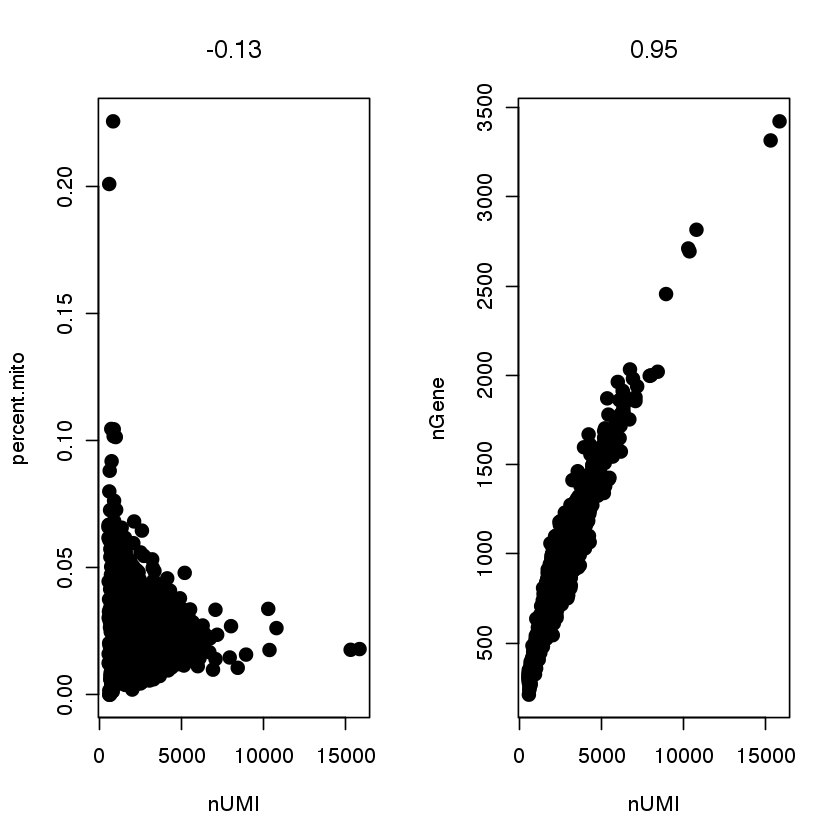

In [4]:
#GenePlot is typically used to visualize gene-gene relationships, but can be used for anything calculated by the object, i.e. columns in object@data.info, PC scores etc.
#Since there is a rare subset of cells with an outlier level of high mitochondrial percentage, and also low UMI content, we filter these as well
par(mfrow = c(1, 2))
GenePlot(pbmc, "nUMI", "percent.mito")
GenePlot(pbmc, "nUMI", "nGene")

In [5]:
#We filter out cells that have unique gene counts over 2,500
#Note that accept.high and accept.low can be used to define a 'gate', and can filter cells not only based on nGene but on anything in the object (as in GenePlot above)
pbmc <- SubsetData(pbmc, subset.name = "nGene", accept.high = 2500)
pbmc <- SubsetData(pbmc, subset.name = "percent.mito", accept.high = 0.05)

In [6]:
previous_time <- proc.time()[3]
#note that this overwrites pbmc@scale.data. Therefore, if you intend to use RegressOut, you can set do.scale=F and do.center=F in the original object to save some time.
pbmc <- RegressOut(pbmc, latent.vars = c("nUMI", "percent.mito"))
proc.time()[3] - previous_time

[1] "Regressing out nUMI"         "Regressing out percent.mito"


elapsed 
129.145

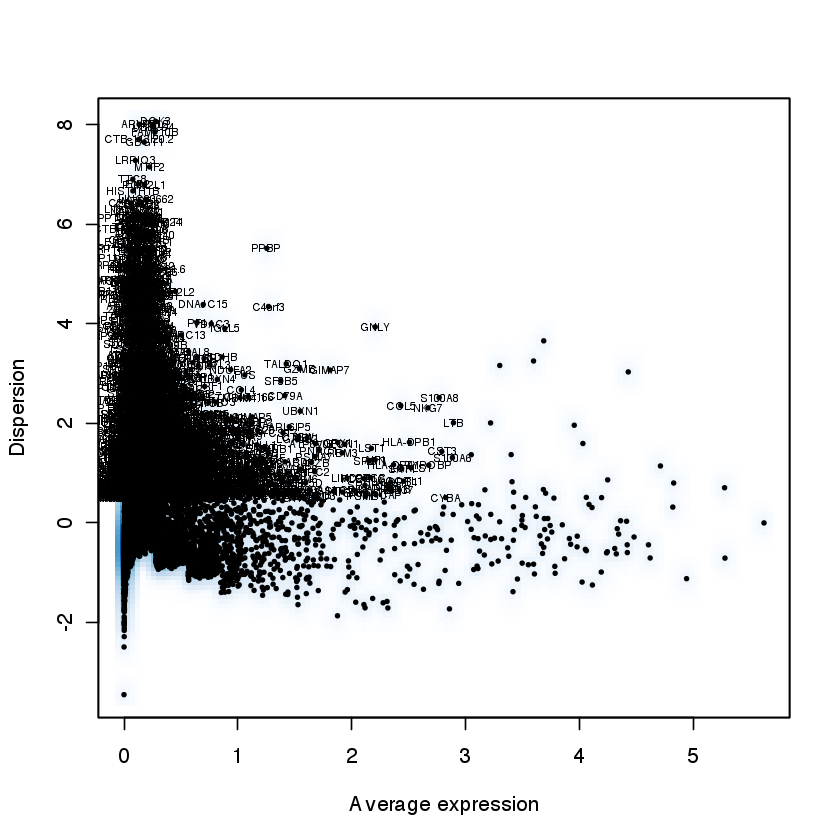

In [7]:
pbmc <- MeanVarPlot(pbmc ,fxn.x = expMean, fxn.y = logVarDivMean, x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5, do.contour = F)

In [8]:
previous_time <- proc.time()[3]
pbmc <- PCA(pbmc, pc.genes = pbmc@var.genes, do.print = TRUE, pcs.print = 5, genes.print = 5)
proc.time()[3] - previous_time

[1] "PC1"
[1] "CST3"   "TYROBP" "FCN1"   "LST1"   "AIF1"  
[1] ""
[1] "PTPRCAP" "IL32"    "LTB"     "CD2"     "CTSW"   
[1] ""
[1] ""
[1] "PC2"
[1] "NKG7" "GZMB" "PRF1" "CST7" "GZMA"
[1] ""
[1] "CD79A"    "MS4A1"    "HLA-DQA1" "TCL1A"    "HLA-DQB1"
[1] ""
[1] ""
[1] "PC3"
[1] "CYBA"     "HLA-DPA1" "HLA-DPB1" "HLA-DRB1" "CD37"    
[1] ""
[1] "PF4"   "PPBP"  "SDPR"  "SPARC" "GNG11"
[1] ""
[1] ""
[1] "PC4"
[1] "IL32"   "GIMAP7" "AQP3"   "FYB"    "MAL"   
[1] ""
[1] "CD79A"    "HLA-DQA1" "CD79B"    "MS4A1"    "HLA-DQB1"
[1] ""
[1] ""
[1] "PC5"
[1] "FCER1A"  "LGALS2"  "MS4A6A"  "S100A8"  "CLEC10A"
[1] ""
[1] "FCGR3A"        "CTD-2006K23.1" "IFITM3"        "ABI3"         
[5] "CEBPB"        
[1] ""
[1] ""


elapsed 
 45.351

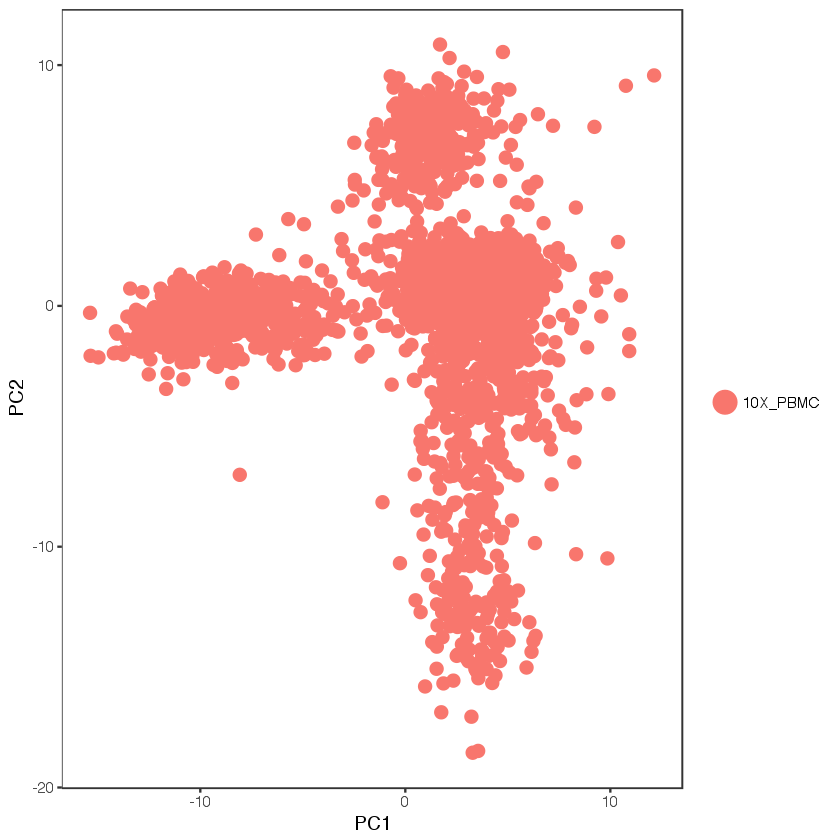

In [9]:
PCAPlot(pbmc, 1, 2)

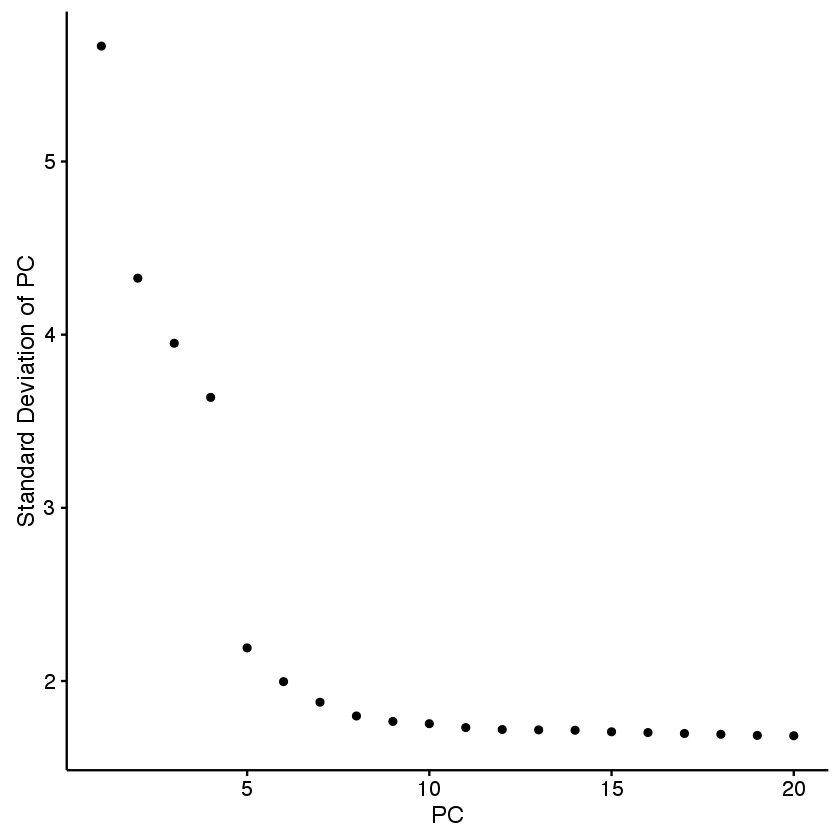

In [10]:
PCElbowPlot(pbmc)

In [11]:
previous_time <- proc.time()[3]
#save.SNN=T saves the SNN so that the  SLM algorithm can be rerun using the same graph, but with a different resolution value (see docs for full details)
pbmc <- FindClusters(pbmc, pc.use = 1:10, resolution = 0.6, print.output = 0, save.SNN = T)
proc.time()[3] - previous_time

elapsed 
 65.707

In [12]:
previous_time <- proc.time()[3]
pbmc <- RunTSNE(pbmc, dims.use = 1:10, do.fast = T)
proc.time()[3] - previous_time

elapsed 
 24.854

In [13]:
previous_time <- proc.time()[3]
# find all markers of cluster 1
cluster1.markers <- FindMarkers(pbmc, ident.1 = 1, min.pct = 0.25)
print(head(cluster1.markers, 5))
proc.time()[3] - previous_time

       p_val avg_diff pct.1 pct.2
S100A9     0 3.827593 0.996 0.216
S100A8     0 3.786535 0.973 0.123
LYZ        0 3.116197 1.000 0.517
LGALS2     0 2.634722 0.908 0.060
FCN1       0 2.369524 0.956 0.150


elapsed 
 13.976

In [15]:
previous_time <- proc.time()[3]
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, 5, c(0,3), min.pct = 0.25)
print(head(cluster5.markers, 5))
proc.time()[3] - previous_time

              p_val   avg_diff pct.1 pct.2
GNLY  3.466387e-171  3.5147178 0.961 0.143
RPS12 4.191523e-170 -1.0195287 0.994 1.000
NKG7  1.266864e-159  2.3523369 1.000 0.307
GZMB  8.416814e-158  3.1950212 0.955 0.084
RPS27 5.655551e-157 -0.9156105 0.987 0.999


elapsed 
 10.415

In [14]:
previous_time <- proc.time()[3]
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(2, avg_diff)
proc.time()[3] - previous_time

p_val,avg_diff,pct.1,pct.2,cluster,gene
1.382491e-268,1.150398,0.925,0.483,0,LDHB
1.625949e-132,1.064122,0.662,0.203,0,IL7R
0.000000e+00,3.827593,0.996,0.216,1,S100A9
0.000000e+00,3.786535,0.973,0.123,1,S100A8
0.000000e+00,2.977399,0.936,0.042,2,CD79A
1.030004e-191,2.492236,0.624,0.022,2,TCL1A
1.404612e-232,2.172409,0.974,0.229,3,CCL5
9.415562e-125,2.110316,0.586,0.050,3,GZMK
1.304430e-165,2.151881,1.000,0.316,4,LST1
1.420369e-138,2.275509,0.962,0.137,4,FCGR3A


elapsed 
 96.132